# Backtesting with [**vectorbt**](https://github.com/polakowo/vectorbt)
* Data Acquisition (**yfinance**)
* Statistical and Technical Analysis (**pandas_ta**)
* Backtesting Analysis and Results (**vectorbt**)

### Initializations

In [2]:
!pip install vectorbt

     |████████████████████████████████| 485 kB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 110 kB 35.9 MB/s eta 0:00:01
     |████████████████████████████████| 293 kB 29.5 MB/s eta 0:00:01
  Using cached schedule-1.1.0-py2.py3-none-any.whl (10 kB)


     |████████████████████████████████| 340 kB 32.4 MB/s eta 0:00:01
  Created wheel for vectorbt: filename=vectorbt-0.24.5-py3-none-any.whl size=526802 sha256=39f29d48aee873163e401ef80a8fe3dd7f3254284aa6c3caa182c8fdeb18d04c
  Stored in directory: /home/steven/.cache/pip/wheels/be/6a/39/9fe1027502bf84c884fcc956eaabdc6196d78daac11ce28f74
Successfully built vectorbt


In [13]:
import asyncio
import itertools
from datetime import datetime

from IPython import display

import numpy as np
import pandas as pd
import pandas_ta as ta
import vectorbt as vbt

import plotly.graph_objects as go

from utils import *

print("Package Versions:")
print(f"Numpy v{np.__version__}")
print(f"Pandas v{pd.__version__}")
print(f"vectorbt >= v0.18.1")
print(f"\nPandas TA v{ta.version}\nTo install the Latest Version:\n$ pip install -U git+https://github.com/twopirllc/pandas-ta\n")

%matplotlib inline

Package Versions:
Numpy v1.21.5
Pandas v1.4.2
vectorbt >= v0.18.1

Pandas TA v0.3.14b0
To install the Latest Version:
$ pip install -U git+https://github.com/twopirllc/pandas-ta



# **vectorbt** Theme and Portfolio Settings

In [14]:
cheight, cwidth = 500, 1000 # Adjust as needed for Chart Height and Width
vbt.settings.set_theme("dark") # Options: "light" (Default), "dark" (my fav), "seaborn"

# Must be set
vbt.settings.portfolio["freq"] = "1m" # Daily

# Predefine vectorbt Portfolio settings
# vbt.settings.portfolio["init_cash"] = 100
vbt.settings.portfolio["fees"] = 0.0025 # 0.25%
vbt.settings.portfolio["slippage"] = 0.0025 # 0.25%
# vbt.settings.portfolio["size"] = 100
# vbt.settings.portfolio["accumulate"] = False
vbt.settings.portfolio["allow_partial"] = False

pf_settings = pd.DataFrame(vbt.settings.portfolio.items(), columns=["Option", "Value"])
pf_settings.set_index("Option", inplace=True)

print(f"Portfolio Settings [Initial]")
pf_settings

Portfolio Settings [Initial]


,Value
Option,
call_seq,default
init_cash,100.0
size,inf
size_type,amount
fees,0.0025
...,...
attach_call_seq,False
fillna_close,True
trades_type,exittrades


## Helper Methods

In [15]:
def combine_stats(pf: vbt.portfolio.base.Portfolio, ticker: str, strategy: str, mode: int = 0):
    header = pd.Series({
        "Run Time": ta.get_time(full=False, to_string=True),
        "Mode": "LIVE" if mode else "TEST",
        "Strategy": strategy,
        "Direction": vbt.settings.portfolio["signal_direction"],
        "Symbol": ticker.upper(),
        "Fees [%]": 100 * vbt.settings.portfolio["fees"],
        "Slippage [%]": 100 * vbt.settings.portfolio["slippage"],
        "Accumulate": vbt.settings.portfolio["accumulate"],
    })
    rstats = pf.returns_stats().dropna(axis=0).T
    stats = pf.stats().dropna(axis=0).T
    joint = pd.concat([header, stats, rstats])
    return joint[~joint.index.duplicated(keep="first")]

def earliest_common_index(d: dict):
    """Returns index of the earliest common index of all DataFrames in the dict"""
    min_date = None
    for df in d.values():
        if min_date is None:
            min_date = df.index[0]
        elif min_date < df.index[0]:
            min_date = df.index[0]
    return min_date

def dl(tickers: list, same_start: bool = False, **kwargs):
    if isinstance(tickers, str):
        tickers = [tickers]
    
    if not isinstance(tickers, list) or len(tickers) == 0:
        print("Must be a non-empty list of tickers or symbols")
        return

    if "limit" in kwargs and kwargs["limit"] and len(tickers) > kwargs["limit"]:
        from itertools import islice            
        tickers = list(islice(tickers, kwargs["limit"]))
        print(f"[!] Too many assets to compare. Using the first {kwargs['limit']}: {', '.join(tickers)}")

    print(f"[i] Downloading: {', '.join(tickers)}")

    received = {}
    if len(tickers):
        _df = pd.DataFrame()
        for ticker in tickers:
            received[ticker] = _df.ta.ticker(ticker, **kwargs)
            print(f"[+] {ticker}{received[ticker].shape} {ta.get_time(full=False, to_string=True)}")
    
    if same_start and len(tickers) > 1:
        earliestci = earliest_common_index(received)
        print(f"[i] Earliest Common Date: {earliestci}")
        result = {ticker:df[df.index > earliestci].copy() for ticker,df in received.items()}
    else:
        result = received
    print(f"[*] Download Complete\n")
    return result

def dtmask(df: pd.DataFrame, start: datetime, end: datetime):
    df['Datetime'] = pd.to_datetime(df.index, utc=True)
    print(df['Datetime'])
    if not df.ta.datetime_ordered:
        df = df.set_index(pd.DatetimeIndex(df['Datetime']))    
    return df.loc[(df.index >= pd.to_datetime(start, utc=True)) & (df.index <= pd.to_datetime(end, utc=True)), :].copy()

def show_data(d: dict):
    [print(f"{t}[{df.index[0]} - {df.index[-1]}]: {df.shape} {df.ta.time_range:.2f} years") for t,df in d.items()]
    
def trade_table(pf: vbt.portfolio.base.Portfolio, k: int = 1, total_fees: bool = False):
    if not isinstance(pf, vbt.portfolio.base.Portfolio): return
    k = int(k) if isinstance(k, int) and k > 0 else 1

    df = pf.trades.records[["status", "direction", "size", "entry_price", "exit_price", "return", "pnl", "entry_fees", "exit_fees"]]
    if total_fees:
        df["total_fees"] = df["entry_fees"] + df["exit_fees"]

    print(f"\nLast {k} of {df.shape[0]} Trades\n{df.tail(k)}\n")

# Data Acquisition

#### Specify Symbols for Benchmarks and Assets

In [16]:
benchmark_tickers = ["SPY", "QQQ"]
asset_tickers = ["AAPL", "TSLA", 
                 "COIN", "U", 
                 "ENPH","TSM",
                 "QCOM","BX",
                 "AMD","NVDA",
                 "MRNA","GUSH",
                 "WSM","MCD",
                 "TLT","TAN"]
all_tickers = benchmark_tickers + asset_tickers

print("Tickers by index #")
print("="*100)
print(f"Benchmarks: {', '.join([f'{k}: {v}' for k,v in enumerate(benchmark_tickers)])}")
print(f"    Assets: {', '.join([f'{k}: {v}' for k,v in enumerate(asset_tickers)])}")
print(f"       All: {', '.join([f'{k}: {v}' for k,v in enumerate(all_tickers)])}")

Tickers by index #
Benchmarks: 0: SPY, 1: QQQ
    Assets: 0: AAPL, 1: TSLA, 2: COIN, 3: U, 4: ENPH, 5: TSM, 6: QCOM, 7: BX, 8: AMD, 9: NVDA, 10: MRNA, 11: GUSH, 12: WSM, 13: MCD, 14: TLT, 15: TAN
       All: 0: SPY, 1: QQQ, 2: AAPL, 3: TSLA, 4: COIN, 5: U, 6: ENPH, 7: TSM, 8: QCOM, 9: BX, 10: AMD, 11: NVDA, 12: MRNA, 13: GUSH, 14: WSM, 15: MCD, 16: TLT, 17: TAN


In [17]:
benchmark = benchmark_tickers[0] # Change index for different benchmark
asset = asset_tickers[2] # Change index for different symbol
print(f"Selected Benchmark | Asset: {benchmark} | {asset}")

Selected Benchmark | Asset: SPY | COIN


In [18]:
# benchmarks = dl(benchmark_tickers, lc_cols=True)
tf = "1m"
benchmarks = retrieve_data(benchmark_tickers, tf=tf)


[!] Loading All: SPY, QQQ
/home/steven/av_data/data/SPY_1m.csv
[i] Loaded SPY[1m]: SPY_1m.csv
[i] Runtime: 114.3350 ms (0.1143 s)
/home/steven/av_data/data/QQQ_1m.csv
[i] Loaded QQQ[1m]: QQQ_1m.csv
[i] Runtime: 108.6386 ms (0.1086 s)


In [19]:
# assets = dl(asset_tickers, lc_cols=True)
assets = retrieve_data(asset_tickers, tf=tf)

assets.tickers

[!] Loading All: AAPL, TSLA, COIN, U, ENPH, TSM, QCOM, BX, AMD, NVDA, MRNA, GUSH, WSM, MCD, TLT, TAN
/home/steven/av_data/data/AAPL_1m.csv
[i] Loaded AAPL[1m]: AAPL_1m.csv
[i] Runtime: 115.3716 ms (0.1154 s)
/home/steven/av_data/data/TSLA_1m.csv
[i] Loaded TSLA[1m]: TSLA_1m.csv
[i] Runtime: 110.0220 ms (0.1100 s)
/home/steven/av_data/data/COIN_1m.csv
[i] Loaded COIN[1m]: COIN_1m.csv
[i] Runtime: 102.1000 ms (0.1021 s)
/home/steven/av_data/data/U_1m.csv
[i] Loaded U[1m]: U_1m.csv
[i] Runtime: 103.6473 ms (0.1036 s)
/home/steven/av_data/data/ENPH_1m.csv
[i] Loaded ENPH[1m]: ENPH_1m.csv
[i] Runtime: 107.2603 ms (0.1073 s)
/home/steven/av_data/data/TSM_1m.csv
[i] Loaded TSM[1m]: TSM_1m.csv
[i] Runtime: 111.7454 ms (0.1117 s)
/home/steven/av_data/data/QCOM_1m.csv
[i] Loaded QCOM[1m]: QCOM_1m.csv
[i] Runtime: 112.1357 ms (0.1121 s)
/home/steven/av_data/data/BX_1m.csv
[i] Loaded BX[1m]: BX_1m.csv
[i] Runtime: 112.7984 ms (0.1128 s)
/home/steven/av_data/data/AMD_1m.csv
[i] Loaded AMD[1m]: AMD_

['AAPL',
 'TSLA',
 'COIN',
 'U',
 'ENPH',
 'TSM',
 'QCOM',
 'BX',
 'AMD',
 'NVDA',
 'MRNA',
 'GUSH',
 'WSM',
 'MCD',
 'TLT',
 'TAN']

### Define Testing Dates and Ranges

In [20]:
start_date = datetime(2010, 1, 1) # Adjust as needed
end_date = datetime(2023, 3, 16)   # Adjust as needed

### Select and Benchmark and Asset to Backtest

In [21]:
print("Available Data:")
print("="*100)
print(f"Benchmarks: {', '.join(benchmarks.tickers)}")
print(f"Assets: {', '.join(assets.tickers)}")

Available Data:
Benchmarks: SPY, QQQ
Assets: AAPL, TSLA, COIN, U, ENPH, TSM, QCOM, BX, AMD, NVDA, MRNA, GUSH, WSM, MCD, TLT, TAN


In [22]:
benchmark_name = "SPY" # Select a Benchmark
asset_name = "TSLA" # Select an Asset

benchmarkdf = benchmarks.data[benchmark_name]
assetdf     = assets.data[asset_name]
assetdf.columns
# Set True if you want to constrain Data between start_date & end_date
common_range = True
if common_range:
    crs = f" from {start_date} to {end_date}"
    benchmarkdf = dtmask(benchmarkdf, start_date, end_date)
    assetdf = dtmask(assetdf, start_date, end_date)

# Update DataFrame names
benchmarkdf.name = benchmark_name
assetdf.name = asset_name
print(f"Analysis of: {benchmarkdf.name} and {assetdf.name}{crs if common_range else ''}")

Datetime
1993-01-29 05:00:00+00:00   1993-01-29 05:00:00+00:00
1993-02-01 05:00:00+00:00   1993-02-01 05:00:00+00:00
1993-02-02 05:00:00+00:00   1993-02-02 05:00:00+00:00
1993-02-03 05:00:00+00:00   1993-02-03 05:00:00+00:00
1993-02-04 05:00:00+00:00   1993-02-04 05:00:00+00:00
                                       ...           
2023-03-10 05:00:00+00:00   2023-03-10 05:00:00+00:00
2023-03-13 04:00:00+00:00   2023-03-13 04:00:00+00:00
2023-03-14 04:00:00+00:00   2023-03-14 04:00:00+00:00
2023-03-15 04:00:00+00:00   2023-03-15 04:00:00+00:00
2023-03-16 04:00:00+00:00   2023-03-16 04:00:00+00:00
Name: Datetime, Length: 7587, dtype: datetime64[ns, UTC]
Datetime
2010-06-29 04:00:00+00:00   2010-06-29 04:00:00+00:00
2010-06-30 04:00:00+00:00   2010-06-30 04:00:00+00:00
2010-07-01 04:00:00+00:00   2010-07-01 04:00:00+00:00
2010-07-02 04:00:00+00:00   2010-07-02 04:00:00+00:00
2010-07-06 04:00:00+00:00   2010-07-06 04:00:00+00:00
                                       ...           
2023-03

#### Sanity Check

In [23]:
benchmarkdf

,Open,High,...,CUMLOGRET_1,SMA_5_CUMLOGRET
Datetime,,,,,
2010-01-04 05:00:00+00:00,87.704913,88.501021,...,1.254918,1.247677
2010-01-05 05:00:00+00:00,88.399565,88.727374,...,1.257561,1.249285
2010-01-06 05:00:00+00:00,88.602466,88.969302,...,1.258265,1.251318
2010-01-07 05:00:00+00:00,88.586880,89.234697,...,1.262478,1.254264
2010-01-08 05:00:00+00:00,88.891271,89.461040,...,1.265800,1.259804
...,...,...,...,...,...
2023-03-09 05:00:00+00:00,399.739990,401.480011,...,2.742572,2.762531
2023-03-10 05:00:00+00:00,390.989990,393.160004,...,2.728037,2.753275
2023-03-13 04:00:00+00:00,381.809998,390.390015,...,2.726611,2.743595


In [24]:
assetdf

,Open,High,...,CUMLOGRET_1,SMA_5_CUMLOGRET
Datetime,,,,,
2010-06-29 04:00:00+00:00,1.266667,1.666667,...,0.000000,NaN
2010-06-30 04:00:00+00:00,1.719333,2.028000,...,-0.002515,NaN
2010-07-01 04:00:00+00:00,1.666667,1.728000,...,-0.084238,NaN
2010-07-02 04:00:00+00:00,1.533333,1.540000,...,-0.218550,NaN
2010-07-06 04:00:00+00:00,1.333333,1.333333,...,-0.394020,-0.139864
...,...,...,...,...,...
2023-03-09 05:00:00+00:00,180.250000,185.179993,...,4.687419,4.763754
2023-03-10 05:00:00+00:00,175.130005,178.289993,...,4.690422,4.737479
2023-03-13 04:00:00+00:00,167.460007,177.350006,...,4.696400,4.716465


## Creating Trading Signals for **vectorbt**
**vectorbt** can create a Backtest using ```vbt.Portfolio.from_signals(*args, **kwargs)``` based on trends can you define with **Pandas TA**.

### Trend Creation
A **Trend** is the result of some calculation or condition of one or more indicators. For simplicity, a _Trend_ is either ```True``` or ```1``` and _No Trend_ is ```False``` or ```0```. Using the **Hello World** of Trends, the **Golden/Death Cross**, it's Trend is _Long_ when ```long = ma(close, 50) > ma(close, 200) ``` and _Short_ when ```short = ma(close, 50) < ma(close, 200) ```. 

In [25]:
# RSI = vbt.IndicatorFactory.from_talib('RSI')
window_delta = 10
def custom_indicator_obv(close, volumn, rsi_window, ma_window_slow,  entry, exit):
    close_5m = close.resample("5T").last()
    print("close_tm",close_5m)
#     rsi = vbt.RSI.run(close,  window = rsi_window).rsi
    obv = vbt.OBV.run(close,  window = rsi_window).rsi
#     print("rsi", rsi)
    ma_window_fast = ma_window_slow - window_delta
    ma_slow = vbt.MA.run(close, ma_window_slow).ma.to_numpy()
    ma_fast = vbt.MA.run(close, ma_window_fast).ma.to_numpy()
    trend = np.where(rsi > exit , -1, 0)
    trend = np.where( (rsi < entry) & (close < ma), 1, trend)
    return trend

def custom_indicator(close, rsi_window, ma_window_slow,  entry, exit):
#     close_5m = close.resample("5T").last()
#     print("close_tm",close_5m)
    rsi = vbt.RSI.run(close,  window = rsi_window).rsi
#     obv = vbt.OBV.run(close,  window = rsi_window).rsi
#     print("rsi", rsi)
    ma_window_fast = ma_window_slow - window_delta
    ma_slow = vbt.MA.run(close, ma_window_slow).ma.to_numpy()
    ma_fast = vbt.MA.run(close, ma_window_fast).ma.to_numpy()    
    trend = np.where((rsi > exit) & (ma_fast < ma_slow), -1, 0)
    trend = np.where( (rsi < entry) & ( ma_fast > ma_slow), 1, trend)
    return trend

def custom_indicator_1m(close, rsi_window = 14,ma_window_slow = 20,  entry = 30, exit = 70):
    close_5m = close.resample("5T").last()
#     print(close_5m)
    rsi = vbt.RSI.run(close_5m,  window = rsi_window).rsi
    rsi, _= rsi.align(close, 
                      broadcast_axis = 0,
                     method = 'ffill',
                     join = 'right')
    rsi = rsi.to_numpy()
    close = close.to_numpy()
    ma_window_fast = ma_window_slow - window_delta
    ma_slow = vbt.MA.run(close, ma_window_slow).ma.to_numpy()
    ma_fast = vbt.MA.run(close, ma_window_fast).ma.to_numpy()
    trend = np.where(rsi > exit , -1, 0)
    trend = np.where( (rsi < entry) & (close < ma), 1, trend)
    return trend

In [26]:
ind = vbt.IndicatorFactory(
    class_name = "Combination",
    short_name = "comb",
    input_names = ["close"],
    param_names = ["rsi_window", 
                   "ma_window_slow", 
#                    "ma_window_fast", 
                   "entry", 
                   "exit"],
    output_names = ["value"]
    ).from_apply_func(
         custom_indicator,
         rsi_window = 14,
         ma_window_slow = 50,
#          ma_window_fast = 20,
         entry = 30,
         exit = 70,         
         keep_pd = True
        )

# rwindow = 14
# mawindow = 50
# ent = 30
# ext = 70
rwindow = np.arange(20,40, step=5, dtype=int)
mawindow_slow = np.arange(30,200, step=10, dtype=int)
# mawindow_fast = np.arange(10,80, step=20, dtype=int)
# if (mawindow_fast > mawindow_slow):
#     mawinow_fast = mawindow_slow - 20
ent = np.arange(20,40, step=5, dtype=int)
ext = np.arange(60,80, step=10, dtype=int)

# res = ind.run(assets_close,
#              rsi_window = rwindow, 
#              ma_window_slow = mawindow_slow,
# #              ma_window_fast = mawindow_fast,
#              entry = ent,
#              exit = ext,
#              param_product = True)
# # print(res.value)
# entries = res.value == 1.0
# exits = res.value == -1.0

# # print(entries)
# # print(exits)
# # print(assets_close.columns)
# pf = vbt.Portfolio.from_signals(assets_close, entries, exits)
# # fig = assets_close.vbt.plot(trace_kwargs=dict(name='Price', line=dict(color='Red')))
# # fig = tsi.vbt.plot(trace_kwargs=dict(name='Price', line=dict(color='blue')), fig=fig)
# # fig.show()
# # print(pf.trades.records_arr)
# # pf.orders.plot().show()
# # pf.plot().show()
# # print(res.value)
# # print(pf.stats())

# # print( pf.total_return())
# returns =  pf.total_return()

# # returns = returns[returns.index.isin(["TSLA"], level="symbol")]

# # returns = returns.groupby(level=["comb_exit", "comb_extry"]).mean()

# print(returns.max())
# print(returns.idxmax())


In [30]:
# Example Long Trends for the selected Asset
# * Uncomment others for exploration or replace them with your own TA Trend Strategy
def trends(df: pd.DataFrame, mamode: str = "sma", fast: int = 50, slow: int = 200):
    return ta.ma(mamode, df.close, length=fast) > ta.ma(mamode, df.close, length=slow) # SMA(fast) > SMA(slow) "Golden/Death Cross"
#     return ta.increasing(ta.ma(mamode, df.close, length=fast)) # Increasing MA(fast)
#     return ta.macd(df.close, fast, slow).iloc[:,1] > 0 # MACD Histogram is positive

def trends_rsi(df: pd.DataFrame, rsi_window: int = 14, ma_window: int = 50, entry: int = 30, exit: int = 70):
    res = ind.run(df.Close,
                 rsi_window = rsi_window, 
                 ma_window_slow = ma_window,
                 entry = entry,
                 exit = exit,
                 param_product = True)
    entries = res.value == 1.0
    exits = res.value == -1.0
#     trend = np.where(exits , -1, 0)
#     trend = np.where( entries, 1, trend)    
#     return  trend # rsi
    return entries


### Display Trends

In [31]:
trend_kwargs = {"mamode": "sma", "fast": 50, "slow": 200}
# (35, 160, 30, 60, 'TSLA')
trend_rsi={"rsi_window": 35, "ma_window": 160, "entry": 30, "exit": 60}

Datetime
2010-01-04 05:00:00+00:00    False
2010-01-05 05:00:00+00:00    False
2010-01-06 05:00:00+00:00    False
2010-01-07 05:00:00+00:00    False
2010-01-08 05:00:00+00:00    False
                             ...  
2023-03-09 05:00:00+00:00    False
2023-03-10 05:00:00+00:00    False
2023-03-13 04:00:00+00:00    False
2023-03-14 04:00:00+00:00    False
2023-03-15 04:00:00+00:00    False
Name: (35, 160, 30, 60, Close), Length: 3322, dtype: bool


<AxesSubplot:title={'center':'SPY Trends'}, xlabel='Datetime'>

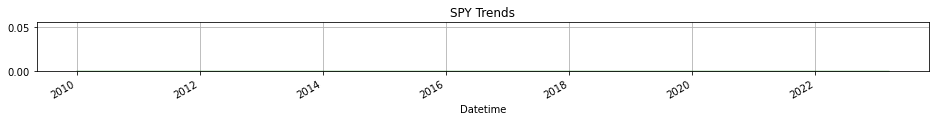

In [32]:
# benchmark_trends = trends(benchmarkdf, **trend_kwargs)
benchmark_trends = trends_rsi(benchmarkdf, **trend_rsi)

print(benchmark_trends)
benchmark_trends.copy().astype(int).plot(figsize=(16, 1), kind="area", color=["green"], alpha=0.45, title=f"{benchmarkdf.name} Trends", grid=True)

<AxesSubplot:title={'center':'TSLA Trends'}, xlabel='Datetime'>

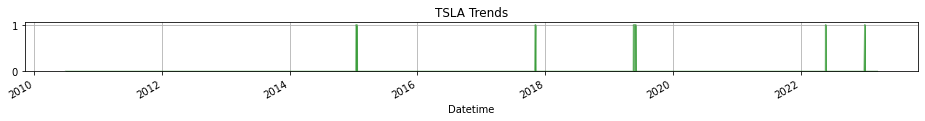

In [33]:
asset_trends = trends_rsi(assetdf, **trend_rsi)
asset_trends.copy().astype(int).plot(figsize=(16, 1), kind="area", color=["green"], alpha=0.45, title=f"{assetdf.name} Trends", grid=True)

### **Trend Signals** 
Given a _Trend_, **Trend Signals** returns the _Trend_, _Trades_, _Entries_ and _Exits_ as boolean integers. When ```asbool=True```, it returns _Trends_, _Entries_ and _Exits_ as boolean values which is helpful when combined with the [**vectorbt**](https://github.com/polakowo/vectorbt) backtesting package.

In [78]:
# trade_offset = 0 for Live Signals (close is last price)
# trade_offset = 1 for Backtesting
LIVE = 0

benchmark_signals = assetdf.ta.tsignals(benchmark_trends, asbool=True, trade_offset=LIVE, append=True)
benchmark_signals.tail()

,TS_Trends,TS_Trades,TS_Entries,TS_Exits
Datetime,,,,
2023-02-22 05:00:00+00:00,False,0,False,False
2023-02-23 05:00:00+00:00,False,0,False,False
2023-02-24 05:00:00+00:00,False,0,False,False
2023-02-27 05:00:00+00:00,False,0,False,False
2023-02-28 05:00:00+00:00,False,0,False,False


In [79]:
asset_signals = assetdf.ta.tsignals(asset_trends, asbool=True, trade_offset=LIVE, append=True)
asset_signals.tail()

,TS_Trends,TS_Trades,TS_Entries,TS_Exits
Datetime,,,,
2023-02-22 05:00:00+00:00,False,0,False,False
2023-02-23 05:00:00+00:00,False,0,False,False
2023-02-24 05:00:00+00:00,False,0,False,False
2023-02-27 05:00:00+00:00,False,0,False,False
2023-02-28 05:00:00+00:00,False,0,False,False


## Creating **vectorbt** Portfolios
* [**vectorbt** Portfolio Options](https://polakowo.io/vectorbt/docs/portfolio/base.html)

### Buy 'N Hold Portfolios with their Single Trade and Performance Statistics

In [80]:
# Benchmark Buy and Hold (BnH) Strategy
benchmarkpf_bnh = vbt.Portfolio.from_holding(benchmarkdf.Close)
print(trade_table(benchmarkpf_bnh))
combine_stats(benchmarkpf_bnh, benchmarkdf.name, "Buy and Hold", LIVE)


Last 1 of 1 Trades
   status  direction  ...  entry_fees  exit_fees
0       0          0  ...    0.249377        0.0

[1 rows x 9 columns]

None


Run Time                         Thursday March 9, 2023, NYSE: 16:24:39
Mode                                                               TEST
Strategy                                                   Buy and Hold
Direction                                                      longonly
Symbol                                                              SPY
                                            ...                        
Tail Ratio                                                     0.933519
Common Sense Ratio    1022083168184449672709936401173511035399288508...
Value at Risk                                                 -0.017052
Alpha                                                         -0.547269
Beta                                                           1.000006
Length: 36, dtype: object

In [81]:
# Asset Buy and Hold (BnH) Strategy
assetpf_bnh = vbt.Portfolio.from_holding(assetdf.Close)
print(trade_table(assetpf_bnh))
combine_stats(assetpf_bnh, assetdf.name, "Buy and Hold", LIVE)


Last 1 of 1 Trades
   status  direction  ...  entry_fees  exit_fees
0       0          0  ...    0.249377        0.0

[1 rows x 9 columns]

None


Run Time              Thursday March 9, 2023, NYSE: 16:24:41
Mode                                                    TEST
Strategy                                        Buy and Hold
Direction                                           longonly
Symbol                                                  TSLA
                                       ...                  
Tail Ratio                                          1.124789
Common Sense Ratio                                       inf
Value at Risk                                      -0.051268
Alpha                                              -0.561316
Beta                                                1.000003
Length: 36, dtype: object

### Signal Portfolios with their Last 'k' Trades and Performance Statistics

In [82]:
# Benchmark Portfolio from Trade Signals
benchmarkpf_signals = vbt.Portfolio.from_signals(
    benchmarkdf.Close,
    entries=benchmark_signals.TS_Entries,
    exits=benchmark_signals.TS_Exits,
)
trade_table(benchmarkpf_signals, k=10)
combine_stats(benchmarkpf_signals, benchmarkdf.name, "Long Strategy", LIVE)


Last 10 of 0 Trades
Empty DataFrame
Columns: [status, direction, size, entry_price, exit_price, return, pnl, entry_fees, exit_fees]
Index: []

[0 rows x 9 columns]



Run Time              Thursday March 9, 2023, NYSE: 16:24:44
Mode                                                    TEST
Strategy                                       Long Strategy
Direction                                           longonly
Symbol                                                   SPY
                                       ...                  
Tail Ratio                                               inf
Common Sense Ratio                                       inf
Value at Risk                                            0.0
Alpha                                                    0.0
Beta                                                     0.0
Length: 33, dtype: object

In [83]:
# Asset Portfolio from Trade Signals
assetpf_signals = vbt.Portfolio.from_signals(
    assetdf.Close,
    entries=asset_signals.TS_Entries,
    exits=asset_signals.TS_Exits,
)
trade_table(assetpf_signals, k=5)
combine_stats(assetpf_signals, assetdf.name, "Long Strategy", LIVE)


Last 5 of 5 Trades
   status  direction  ...  entry_fees  exit_fees
0       1          0  ...    0.249377   0.254211
1       1          0  ...    0.252943   0.254400
2       1          0  ...    0.253131   0.237769
3       1          0  ...    0.236583   0.246886
4       1          0  ...    0.245654   0.256956

[5 rows x 9 columns]



Run Time              Thursday March 9, 2023, NYSE: 16:24:46
Mode                                                    TEST
Strategy                                       Long Strategy
Direction                                           longonly
Symbol                                                  TSLA
                                       ...                  
Tail Ratio                                               inf
Common Sense Ratio                                       inf
Value at Risk                                            0.0
Alpha                                               0.528088
Beta                                                0.004396
Length: 45, dtype: object

## Buy and Hold Plots

In [84]:
vbt.settings.set_theme("seaborn")

### Benchmark

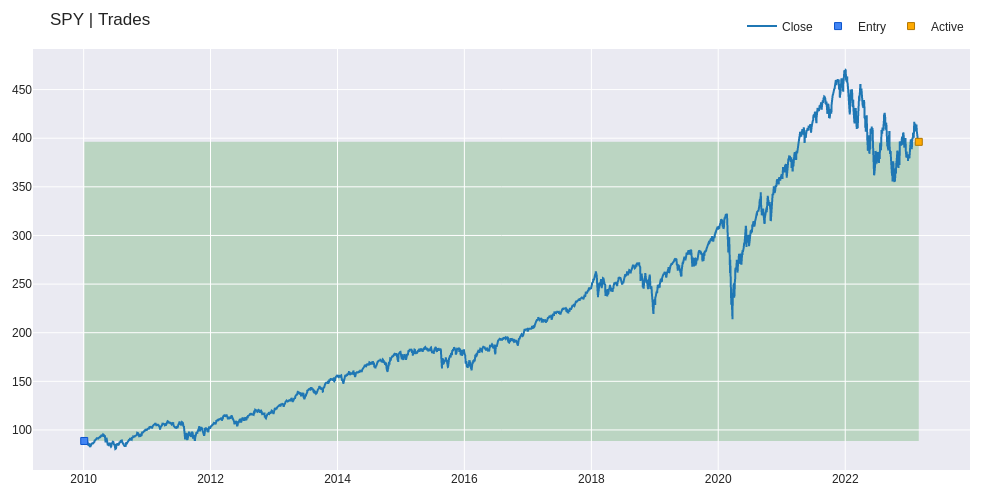

In [85]:
benchmarkpf_bnh.trades.plot(title=f"{benchmarkdf.name} | Trades", height=cheight, width=cwidth).show_png()

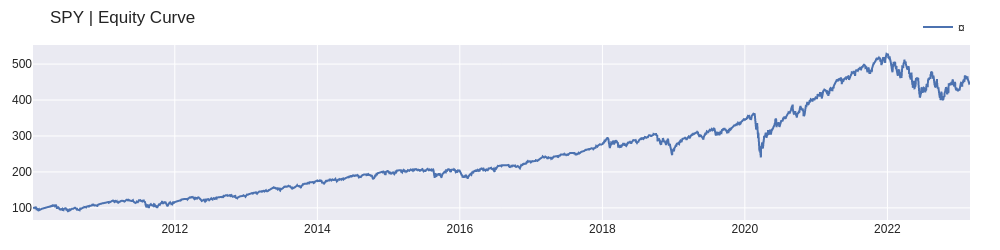

In [86]:
benchmarkpf_bnh.value().vbt.plot(title=f"{benchmarkdf.name} | Equity Curve", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

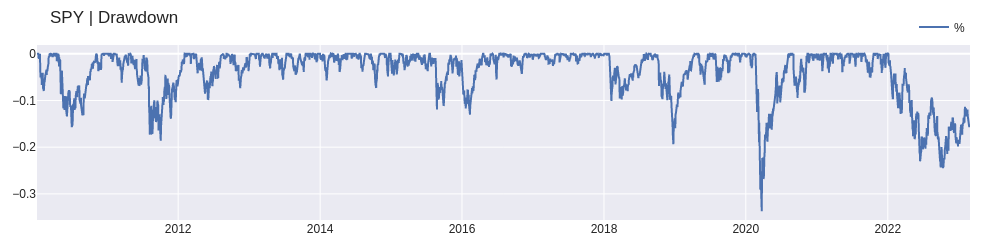

In [87]:
benchmarkpf_bnh.drawdown().vbt.plot(title=f"{benchmarkdf.name} | Drawdown", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

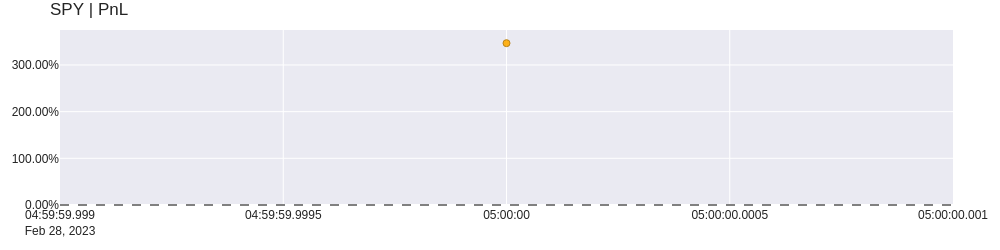

In [88]:
benchmarkpf_bnh.trades.plot_pnl(title=f"{benchmarkdf.name} | PnL", height=cheight // 2, width=cwidth).show_png()

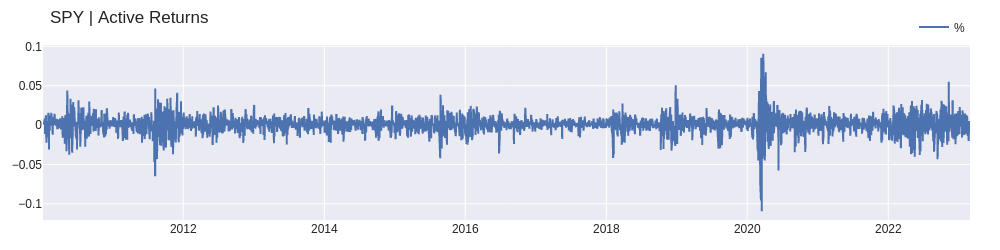

In [89]:
benchmarkpf_bnh.asset_returns().vbt.plot(title=f"{benchmarkdf.name} | Active Returns", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

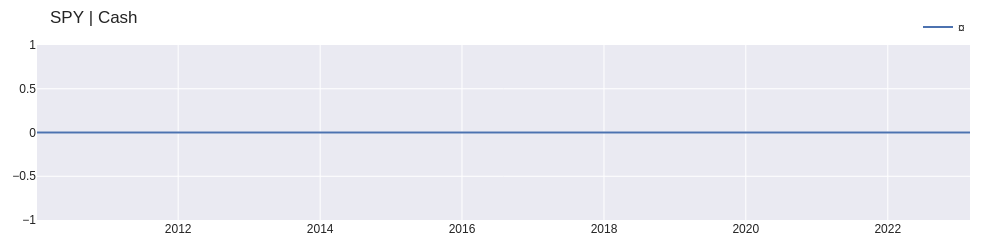

In [90]:
benchmarkpf_bnh.cash().vbt.plot(title=f"{benchmarkdf.name} | Cash", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

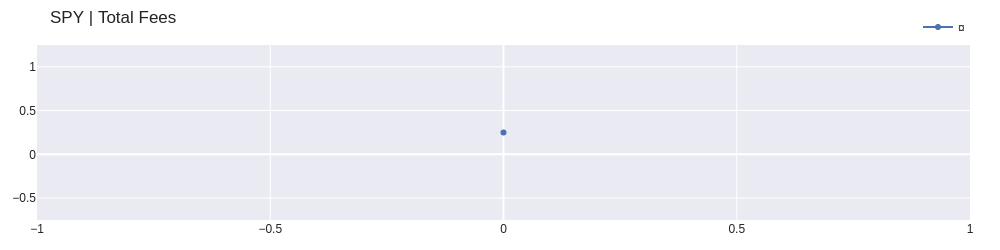

In [91]:
total_assetfees = benchmarkpf_bnh.trades.records_readable["Entry Fees"] + benchmarkpf_bnh.trades.records_readable["Exit Fees"]
total_assetfees.vbt.plot(title=f"{benchmarkdf.name} | Total Fees", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

### Asset

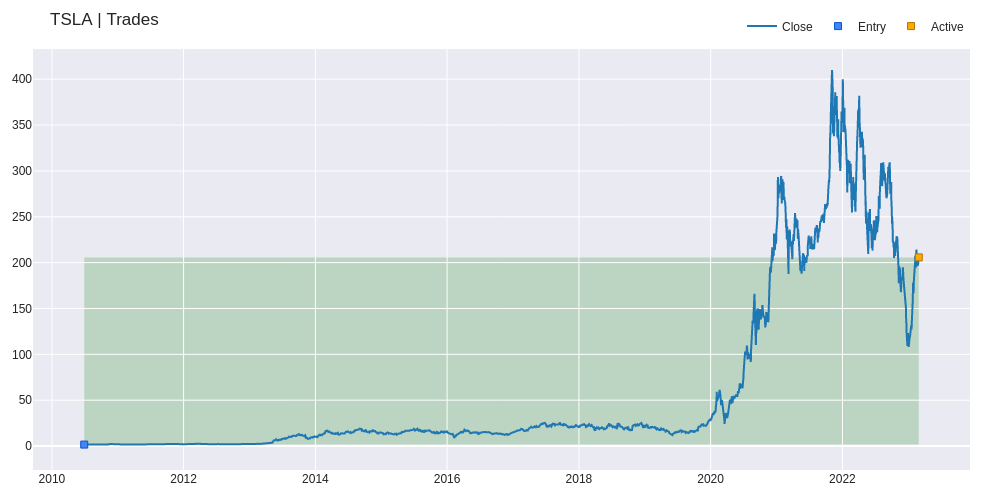

In [92]:
fig = assetpf_bnh.trades.plot(title=f"{assetdf.name} | Trades", height=cheight, width=cwidth).show_png()

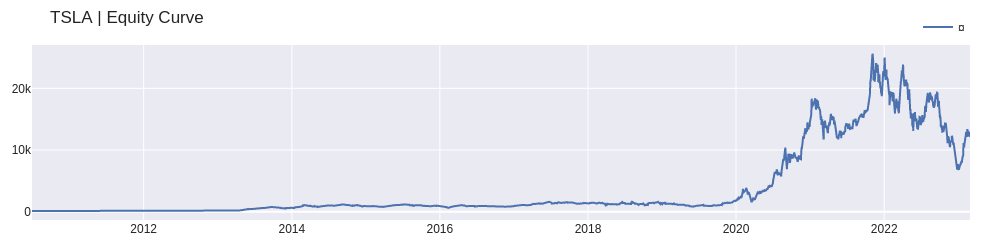

In [93]:
assetpf_bnh.value().vbt.plot(title=f"{assetdf.name} | Equity Curve", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

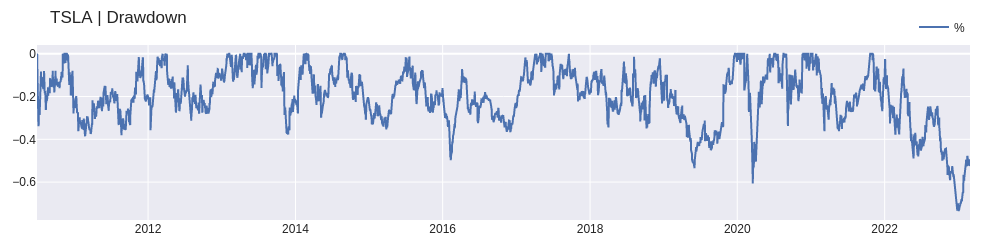

In [94]:
assetpf_bnh.drawdown().vbt.plot(title=f"{assetdf.name} | Drawdown", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

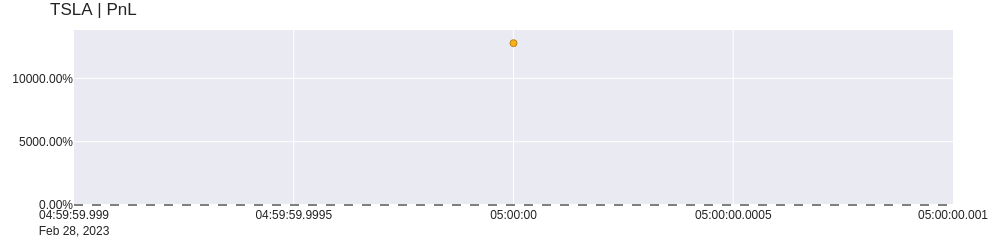

In [95]:
assetpf_bnh.trades.plot_pnl(title=f"{assetdf.name} | PnL", height=cheight // 2, width=cwidth).show_png()

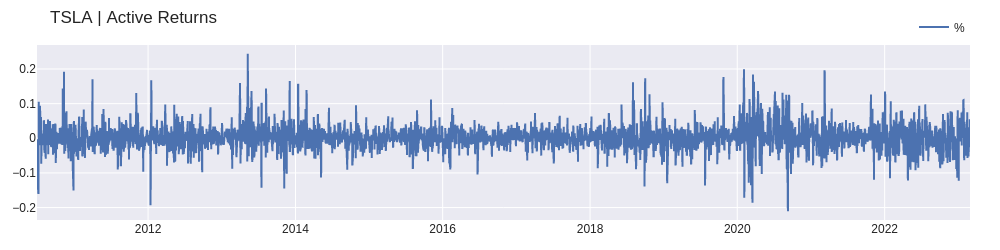

In [96]:
assetpf_bnh.asset_returns().vbt.plot(title=f"{assetdf.name} | Active Returns", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

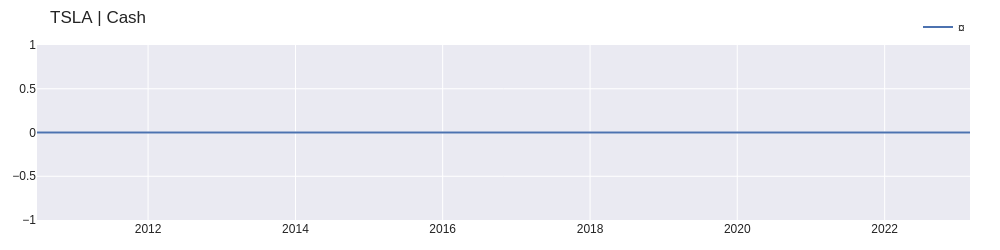

In [97]:
assetpf_bnh.cash().vbt.plot(title=f"{assetdf.name} | Cash", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

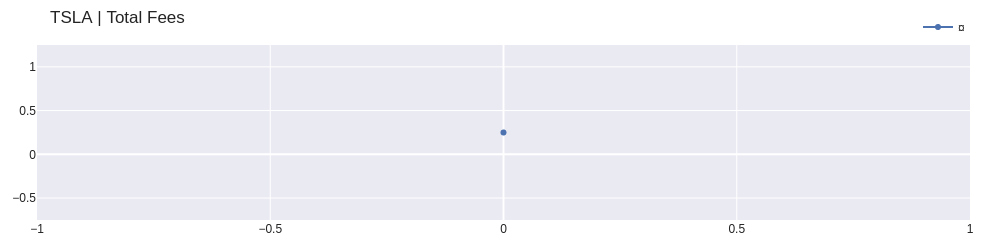

In [98]:
total_assetfees = assetpf_bnh.trades.records_readable["Entry Fees"] + assetpf_bnh.trades.records_readable["Exit Fees"]
total_assetfees.vbt.plot(title=f"{assetdf.name} | Total Fees", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

## Signal Plots

In [99]:
vbt.settings.set_theme("dark")

### Benchmark

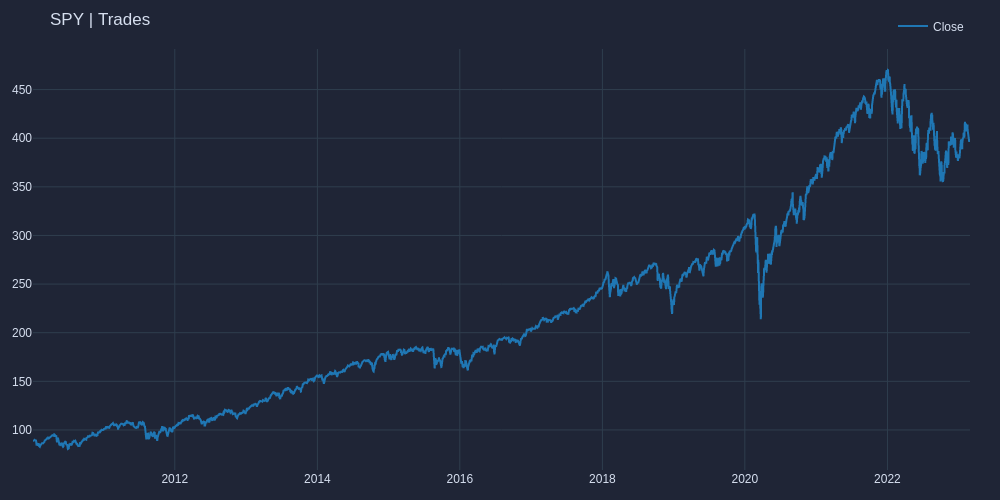

In [100]:
benchmarkpf_signals.trades.plot(title=f"{benchmarkdf.name} | Trades", height=cheight, width=cwidth).show_png()

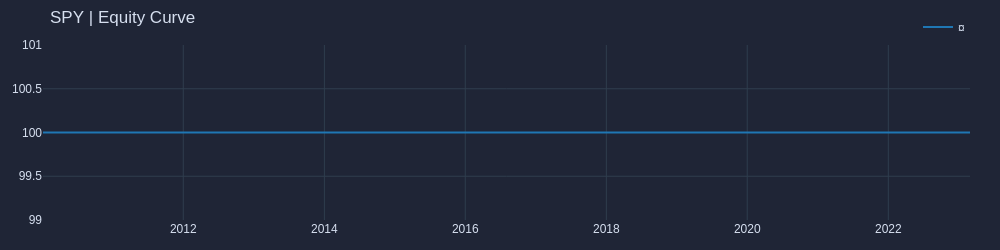

In [101]:
benchmarkpf_signals.value().vbt.plot(title=f"{benchmarkdf.name} | Equity Curve", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

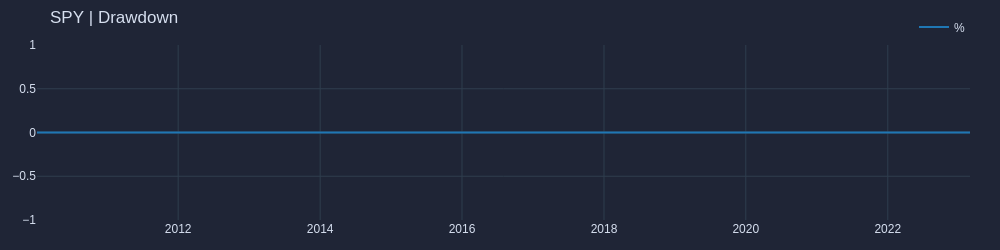

In [102]:
benchmarkpf_signals.drawdown().vbt.plot(title=f"{benchmarkdf.name} | Drawdown", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

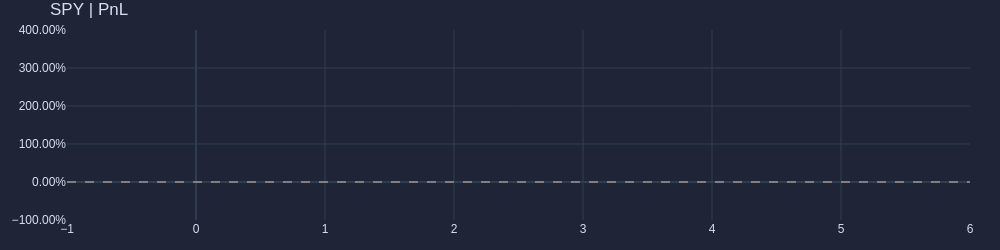

In [103]:
benchmarkpf_signals.trades.plot_pnl(title=f"{benchmarkdf.name} | PnL", height=cheight // 2, width=cwidth).show_png()

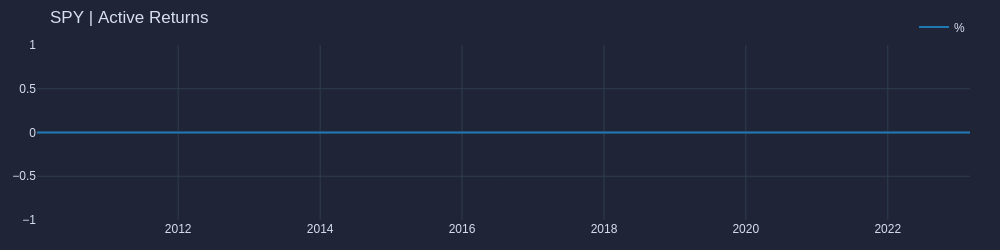

In [104]:
benchmarkpf_signals.asset_returns().vbt.plot(title=f"{benchmarkdf.name} | Active Returns", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

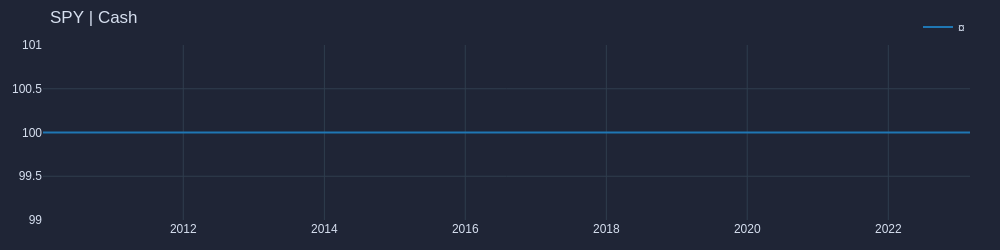

In [105]:
benchmarkpf_signals.cash().vbt.plot(title=f"{benchmarkdf.name} | Cash", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

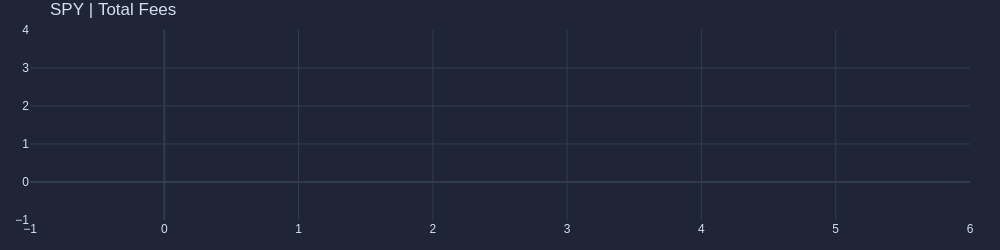

In [106]:
total_assetfees = benchmarkpf_signals.trades.records_readable["Entry Fees"] + benchmarkpf_signals.trades.records_readable["Exit Fees"]
total_assetfees.vbt.plot(title=f"{benchmarkdf.name} | Total Fees", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

### Asset

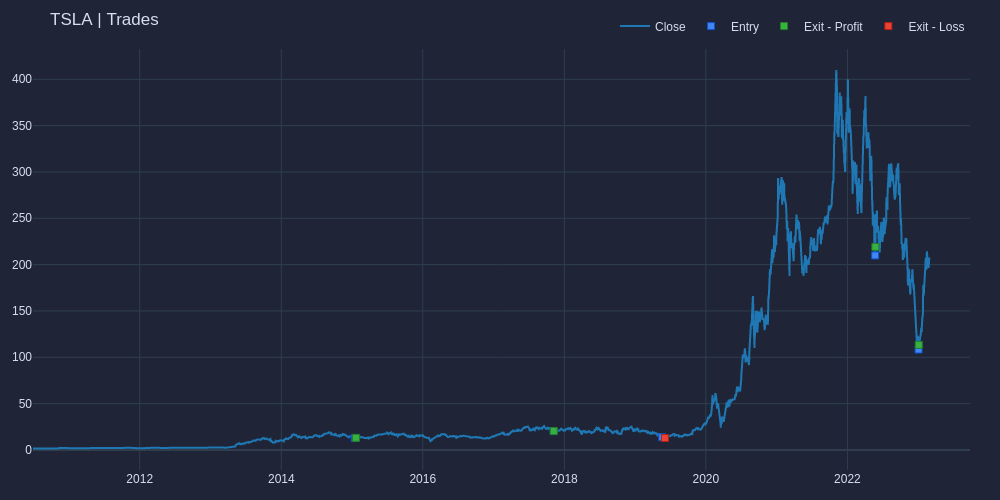

In [107]:
assetpf_signals.trades.plot(title=f"{assetdf.name} | Trades", height=cheight, width=cwidth).show_png()

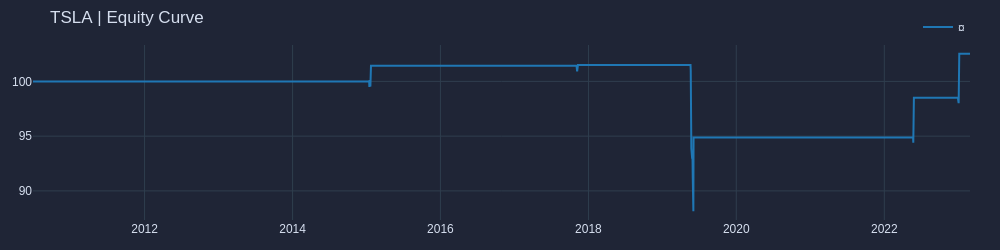

In [108]:
assetpf_signals.value().vbt.plot(title=f"{assetdf.name} | Equity Curve", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

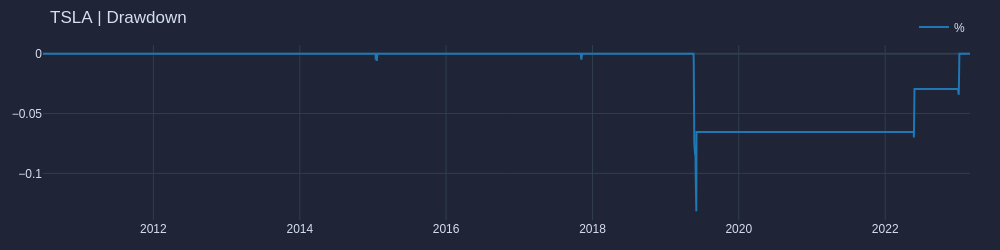

In [109]:
assetpf_signals.drawdown().vbt.plot(title=f"{assetdf.name} | Drawdown", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

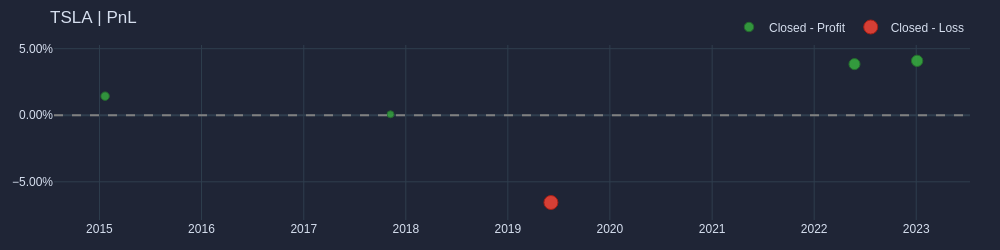

In [110]:
assetpf_signals.trades.plot_pnl(title=f"{assetdf.name} | PnL", height=cheight // 2, width=cwidth).show_png()

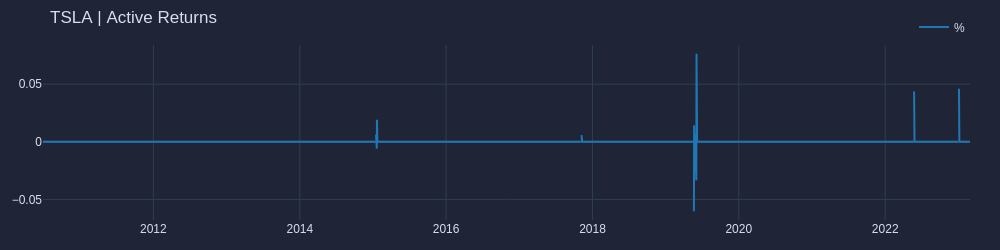

In [111]:
assetpf_signals.asset_returns().vbt.plot(title=f"{assetdf.name} | Active Returns", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

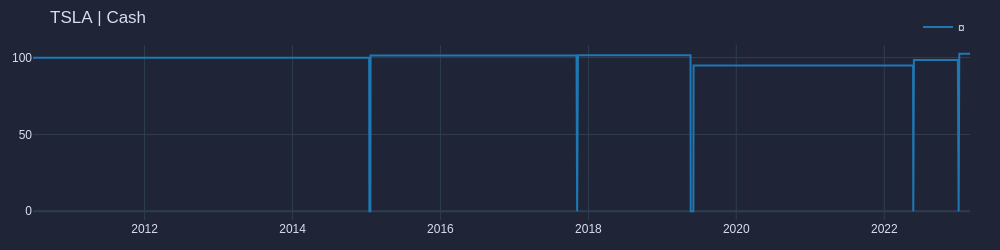

In [112]:
assetpf_signals.cash().vbt.plot(title=f"{assetdf.name} | Cash", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

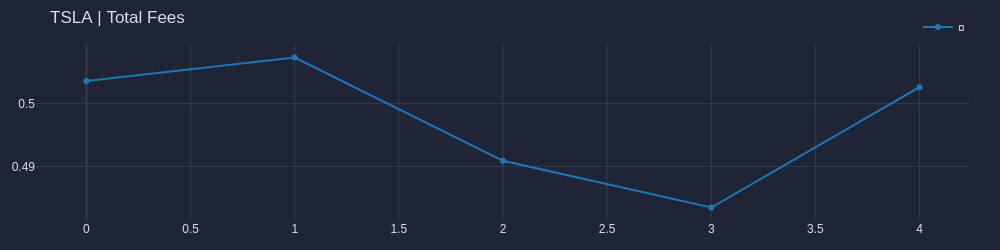

In [113]:
total_assetfees = assetpf_signals.trades.records_readable["Entry Fees"] + assetpf_signals.trades.records_readable["Exit Fees"]
total_assetfees.vbt.plot(title=f"{assetdf.name} | Total Fees", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

# Disclaimer
* All investments involve risk, and the past performance of a security, industry, sector, market, financial product, trading strategy, or individual’s trading does not guarantee future results or returns. Investors are fully responsible for any investment decisions they make. Such decisions should be based solely on an evaluation of their financial circumstances, investment objectives, risk tolerance, and liquidity needs.

* Any opinions, news, research, analyses, prices, or other information offered is provided as general market commentary, and does not constitute investment advice. I will not accept liability for any loss or damage, including without limitation any loss of profit, which may arise directly or indirectly from use of or reliance on such information.